In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.20.0


Generating synthetic multivariate time series dataset...

Dataset Shape: (2000, 3)

First 5 rows of the dataset:
   feature_1  feature_2  feature_3  timestamp
0   0.149014  -0.030726  -0.345397   0.000000
1  -0.009949  -0.031153   0.025236   0.010005
2   0.257360   0.031098   0.082635   0.020010
3   0.551472   0.338582   0.302179   0.030015
4   0.055804  -0.320802  -0.395935   0.040020

Dataset Statistics:
         feature_1    feature_2    feature_3    timestamp
count  2000.000000  2000.000000  2000.000000  2000.000000
mean      0.113525     0.078179    -0.019202    10.000000
std       1.587683     1.524439     2.176983     5.777835
min      -2.795170    -3.494769    -3.953112     0.000000
25%      -1.406010    -0.996569    -2.126045     5.000000
50%       0.118536     0.074807    -0.023150    10.000000
75%       1.632595     1.170215     2.046345    15.000000
max       2.980145     3.568515     3.973041    20.000000


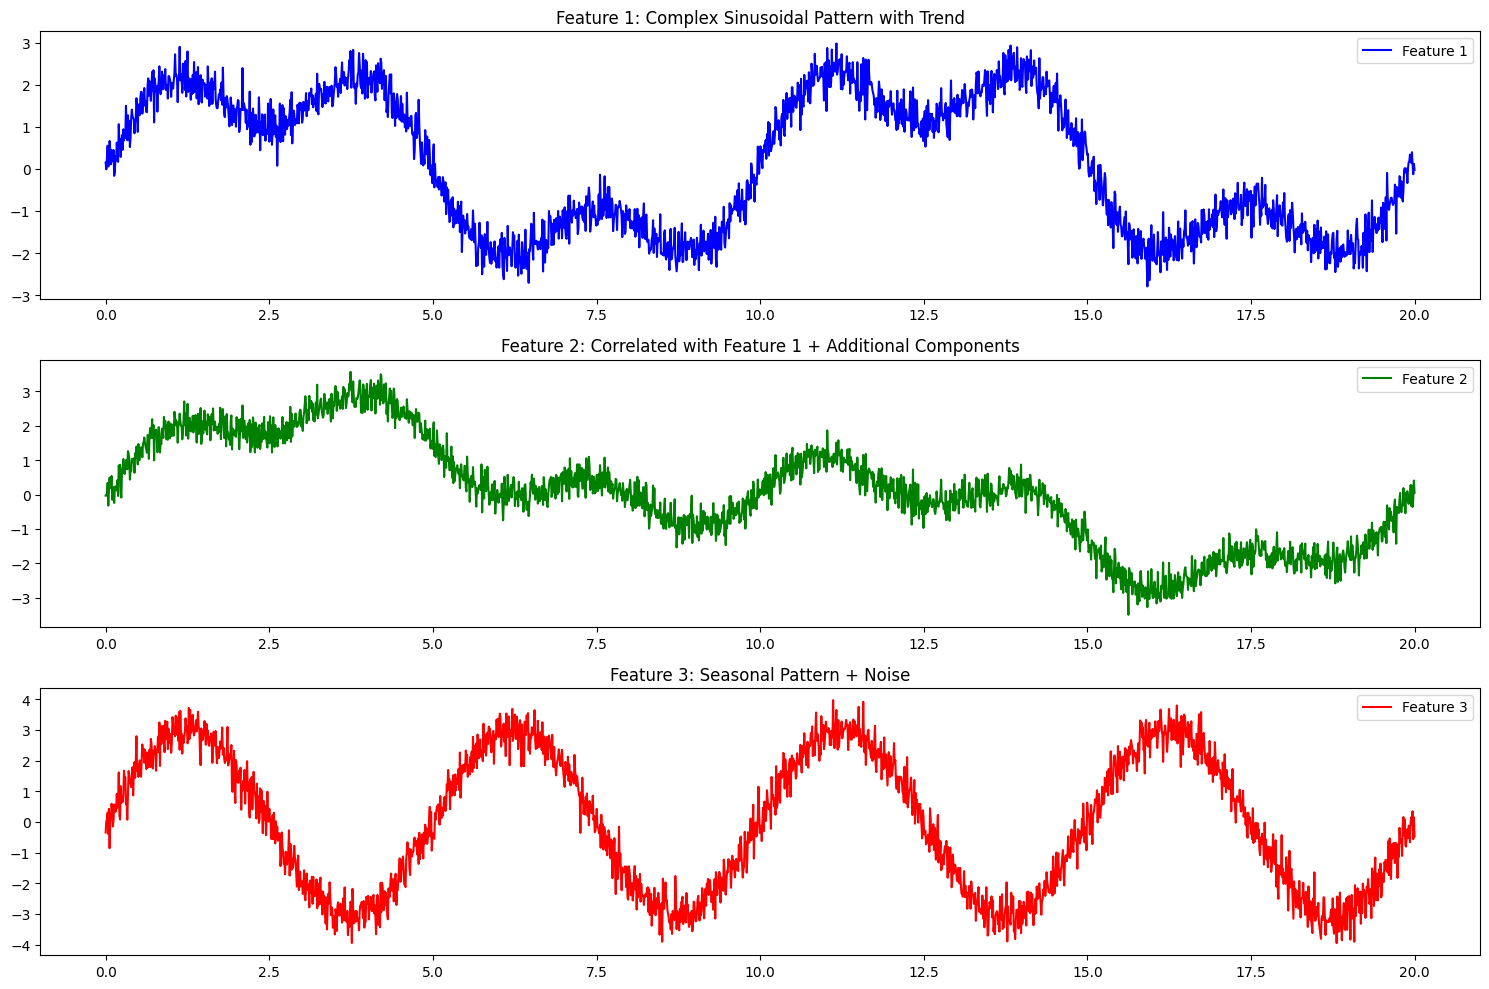


Correlation Matrix:
           feature_1  feature_2  feature_3
feature_1   1.000000   0.705275  -0.011596
feature_2   0.705275   1.000000  -0.005327
feature_3  -0.011596  -0.005327   1.000000


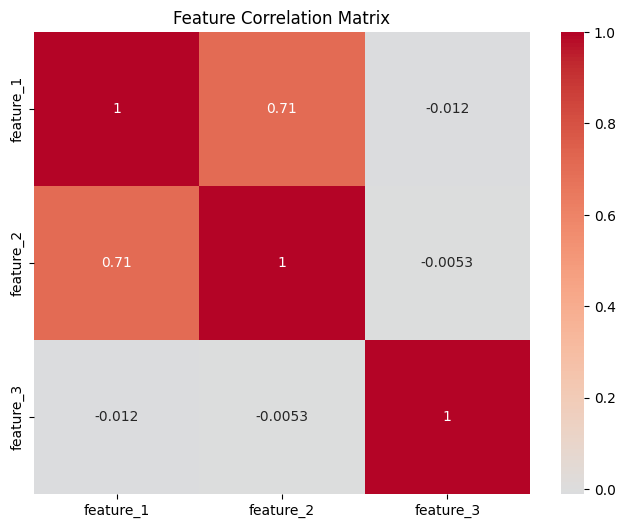

In [2]:
class TimeSeriesDatasetGenerator:
    """
    A class to generate synthetic multivariate time series datasets
    with complex patterns and correlations between features.
    """
    
    def __init__(self, sequence_length=1000, n_features=3):
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.time = np.linspace(0, 20, sequence_length)
        
    def generate_complex_dataset(self):
        """
        Generate a multivariate time series dataset with:
        - Feature 1: Complex sinusoidal pattern with trend
        - Feature 2: Correlated with Feature 1 + additional frequency
        - Feature 3: Seasonal pattern + noise
        """
        
        # Feature 1: Complex sinusoidal pattern with trend
        trend = 0.01 * self.time
        seasonal_1 = 2 * np.sin(2 * np.pi * 0.1 * self.time)  # Low frequency
        seasonal_2 = 1 * np.sin(2 * np.pi * 0.3 * self.time)  # Medium frequency
        noise_1 = 0.3 * np.random.normal(0, 1, self.sequence_length)
        feature_1 = trend + seasonal_1 + seasonal_2 + noise_1
        
        # Feature 2: Correlated with Feature 1 + additional components
        correlation_component = 0.7 * feature_1
        additional_seasonal = 1.5 * np.sin(2 * np.pi * 0.05 * self.time)
        noise_2 = 0.2 * np.random.normal(0, 1, self.sequence_length)
        feature_2 = correlation_component + additional_seasonal + noise_2
        
        # Feature 3: Different seasonal pattern + noise
        seasonal_3 = 3 * np.sin(2 * np.pi * 0.2 * self.time)
        noise_3 = 0.4 * np.random.normal(0, 1, self.sequence_length)
        feature_3 = seasonal_3 + noise_3
        
        # Combine features
        dataset = np.column_stack([feature_1, feature_2, feature_3])
        
        # Create DataFrame for better visualization
        columns = [f'feature_{i+1}' for i in range(self.n_features)]
        df = pd.DataFrame(dataset, columns=columns)
        df['timestamp'] = self.time
        
        return df, dataset
    
    def create_sequences(self, data, seq_length=50, forecast_horizon=1):
        """
        Create sequences for time series forecasting
        """
        X, y = [], []
        for i in range(len(data) - seq_length - forecast_horizon + 1):
            X.append(data[i:(i + seq_length)])
            y.append(data[i + seq_length:i + seq_length + forecast_horizon, 0])  # Predict first feature
        return np.array(X), np.array(y)

# Generate the dataset
print("Generating synthetic multivariate time series dataset...")
generator = TimeSeriesDatasetGenerator(sequence_length=2000, n_features=3)
df, dataset = generator.generate_complex_dataset()

# Display dataset information
print("\nDataset Shape:", dataset.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDataset Statistics:")
print(df.describe())

# Visualize the dataset
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['timestamp'], df['feature_1'], label='Feature 1', color='blue')
plt.title('Feature 1: Complex Sinusoidal Pattern with Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['timestamp'], df['feature_2'], label='Feature 2', color='green')
plt.title('Feature 2: Correlated with Feature 1 + Additional Components')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['timestamp'], df['feature_3'], label='Feature 3', color='red')
plt.title('Feature 3: Seasonal Pattern + Noise')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation analysis
print("\nCorrelation Matrix:")
correlation_matrix = df[['feature_1', 'feature_2', 'feature_3']].corr()
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [3]:
class DataPreprocessor:
    """
    Handles data scaling and sequence preparation for time series forecasting
    """
    
    def __init__(self):
        self.scalers = {}
        
    def fit_transform(self, data):
        """Fit and transform the data using MinMaxScaler"""
        scaled_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            self.scalers[i] = MinMaxScaler(feature_range=(0, 1))
            scaled_data[:, i] = self.scalers[i].fit_transform(data[:, i].reshape(-1, 1)).flatten()
        return scaled_data
    
    def transform(self, data):
        """Transform data using fitted scalers"""
        scaled_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            scaled_data[:, i] = self.scalers[i].transform(data[:, i].reshape(-1, 1)).flatten()
        return scaled_data
    
    def inverse_transform(self, data, feature_idx=0):
        """Inverse transform for specific feature"""
        return self.scalers[feature_idx].inverse_transform(data.reshape(-1, 1)).flatten()

# Preprocess the data
print("Preprocessing data...")
preprocessor = DataPreprocessor()
scaled_data = preprocessor.fit_transform(dataset)

# Create sequences
SEQ_LENGTH = 60
FORECAST_HORIZON = 1

X, y = generator.create_sequences(scaled_data, seq_length=SEQ_LENGTH, 
                                 forecast_horizon=FORECAST_HORIZON)

print(f"Sequences shape: {X.shape}")
print(f"Targets shape: {y.shape}")

# Train-test split
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Preprocessing data...
Sequences shape: (1940, 60, 3)
Targets shape: (1940, 1)
Training set: (1552, 60, 3), (1552, 1)
Test set: (388, 60, 3), (388, 1)


In [4]:
class AttentionLayer(layers.Layer):
    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        feature_dim = input_shape[-1]

        self.W = self.add_weight(
            shape=(feature_dim, self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="W"
        )

        self.V = self.add_weight(
            shape=(self.units, 1),
            initializer="glorot_uniform",
            trainable=True,
            name="V"
        )

    def call(self, inputs):
        # inputs : (batch, seq_len, features)
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1))
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.V, axes=1), axis=1)

        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config

def create_attention_lstm_model(seq_length, n_features, lstm_units=50, 
                              attention_units=32, learning_rate=0.001):

    inputs = layers.Input(shape=(seq_length, n_features))

    lstm_out = layers.LSTM(lstm_units, return_sequences=True)(inputs)

    context_vector, attention_weights = AttentionLayer(units=attention_units)(lstm_out)

    outputs = layers.Dense(1)(context_vector)

    model = keras.Model(inputs=inputs, outputs=outputs)

    attention_model = keras.Model(inputs=inputs, outputs=[outputs, attention_weights])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model, attention_model



def create_baseline_lstm_model(seq_length, n_features, lstm_units=50, learning_rate=0.001):

    model = keras.Sequential([
        layers.LSTM(lstm_units, input_shape=(seq_length, n_features)),
        layers.Dense(1)
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

print("Creating models...")

attention_model, attention_model_with_weights = create_attention_lstm_model(
    SEQ_LENGTH, X.shape[2],
    lstm_units=64,
    attention_units=32,
    learning_rate=0.001
)

baseline_model = create_baseline_lstm_model(
    SEQ_LENGTH, X.shape[2],
    lstm_units=64,
    learning_rate=0.001
)

print("Attention model created!")
print(attention_model.summary())

print("\nBaseline model created!")
print(baseline_model.summary())


Creating models...

Attention model created!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 3)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ [(None, 64), (None, 60, 1)] │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,553 (76.38 KB)

 Trainable params: 19,553 (76.38 KB)

 Non-trainable params: 0 (0.00 B)

None

Baseline model created!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Final training set: (1241, 60, 3)
Validation set: (311, 60, 3)
Training Attention-LSTM model...
Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - loss: 0.0887 - mae: 0.2148 - val_loss: 0.0173 - val_mae: 0.1164 - learning_rate: 0.0010
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0145 - mae: 0.0971 - val_loss: 0.0140 - val_mae: 0.1011 - learning_rate: 0.0010
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0101 - mae: 0.0820 - val_loss: 0.0148 - val_mae: 0.1051 - learning_rate: 0.0010
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0096 - mae: 0.0804 - val_loss: 0.0160 - val_mae: 0.1076 - learning_rate: 0.0010
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0092 - mae: 0.0789 - val_loss: 0.0181 - val_mae: 0.1124 - learning_rate: 0.0010
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0088 - mae: 0.0775 - val_loss: 0.0208 - val_mae: 0.1194 - learning_rate: 0.0010
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/ste

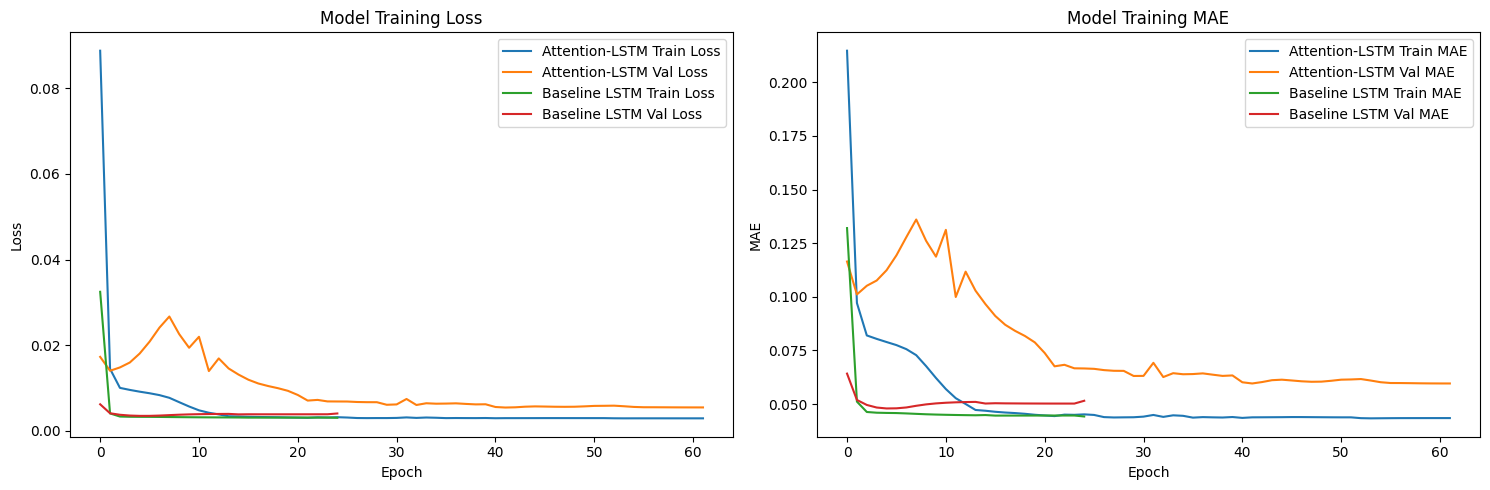

In [5]:
class ModelTrainer:
    """
    Handles model training, validation, and hyperparameter optimization
    """
    
    def __init__(self):
        self.history = {}
        
    def train_model(self, model, X_train, y_train, X_val, y_val, 
                   epochs=100, batch_size=32, patience=15, model_name='model'):
        """Train model with early stopping"""
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=patience, restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7
        )
        
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        self.history[model_name] = history
        return history
    
    def evaluate_model(self, model, X_test, y_test, scaler, feature_idx=0):
        """Evaluate model performance"""
        y_pred = model.predict(X_test)
        
        # Inverse transform predictions and actual values
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1), feature_idx)
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1), feature_idx)
        
        # Calculate metrics
        mse = mean_squared_error(y_test_inv, y_pred_inv)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        
        return rmse, mae, y_pred_inv, y_test_inv

# Create validation set
val_split = 0.2
val_idx = int(len(X_train) * (1 - val_split))

X_tr, X_val = X_train[:val_idx], X_train[val_idx:]
y_tr, y_val = y_train[:val_idx], y_train[val_idx:]

print(f"Final training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")

# Train models
trainer = ModelTrainer()

print("Training Attention-LSTM model...")
attention_history = trainer.train_model(
    attention_model, X_tr, y_tr, X_val, y_val,
    epochs=150, batch_size=32, patience=20, model_name='attention_lstm'
)

print("\nTraining Baseline LSTM model...")
baseline_history = trainer.train_model(
    baseline_model, X_tr, y_tr, X_val, y_val,
    epochs=150, batch_size=32, patience=20, model_name='baseline_lstm'
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(attention_history.history['loss'], label='Attention-LSTM Train Loss')
plt.plot(attention_history.history['val_loss'], label='Attention-LSTM Val Loss')
plt.plot(baseline_history.history['loss'], label='Baseline LSTM Train Loss')
plt.plot(baseline_history.history['val_loss'], label='Baseline LSTM Val Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(attention_history.history['mae'], label='Attention-LSTM Train MAE')
plt.plot(attention_history.history['val_mae'], label='Attention-LSTM Val MAE')
plt.plot(baseline_history.history['mae'], label='Baseline LSTM Train MAE')
plt.plot(baseline_history.history['val_mae'], label='Baseline LSTM Val MAE')
plt.title('Model Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Evaluating models...
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

MODEL PERFORMANCE COMPARISON
Model                RMSE       MAE        Improvement    
--------------------------------------------------
Attention-LSTM       0.3941     0.3188     -              
Baseline LSTM        0.3157     0.2493     -              
Improvement %        -          -          -24.83         %


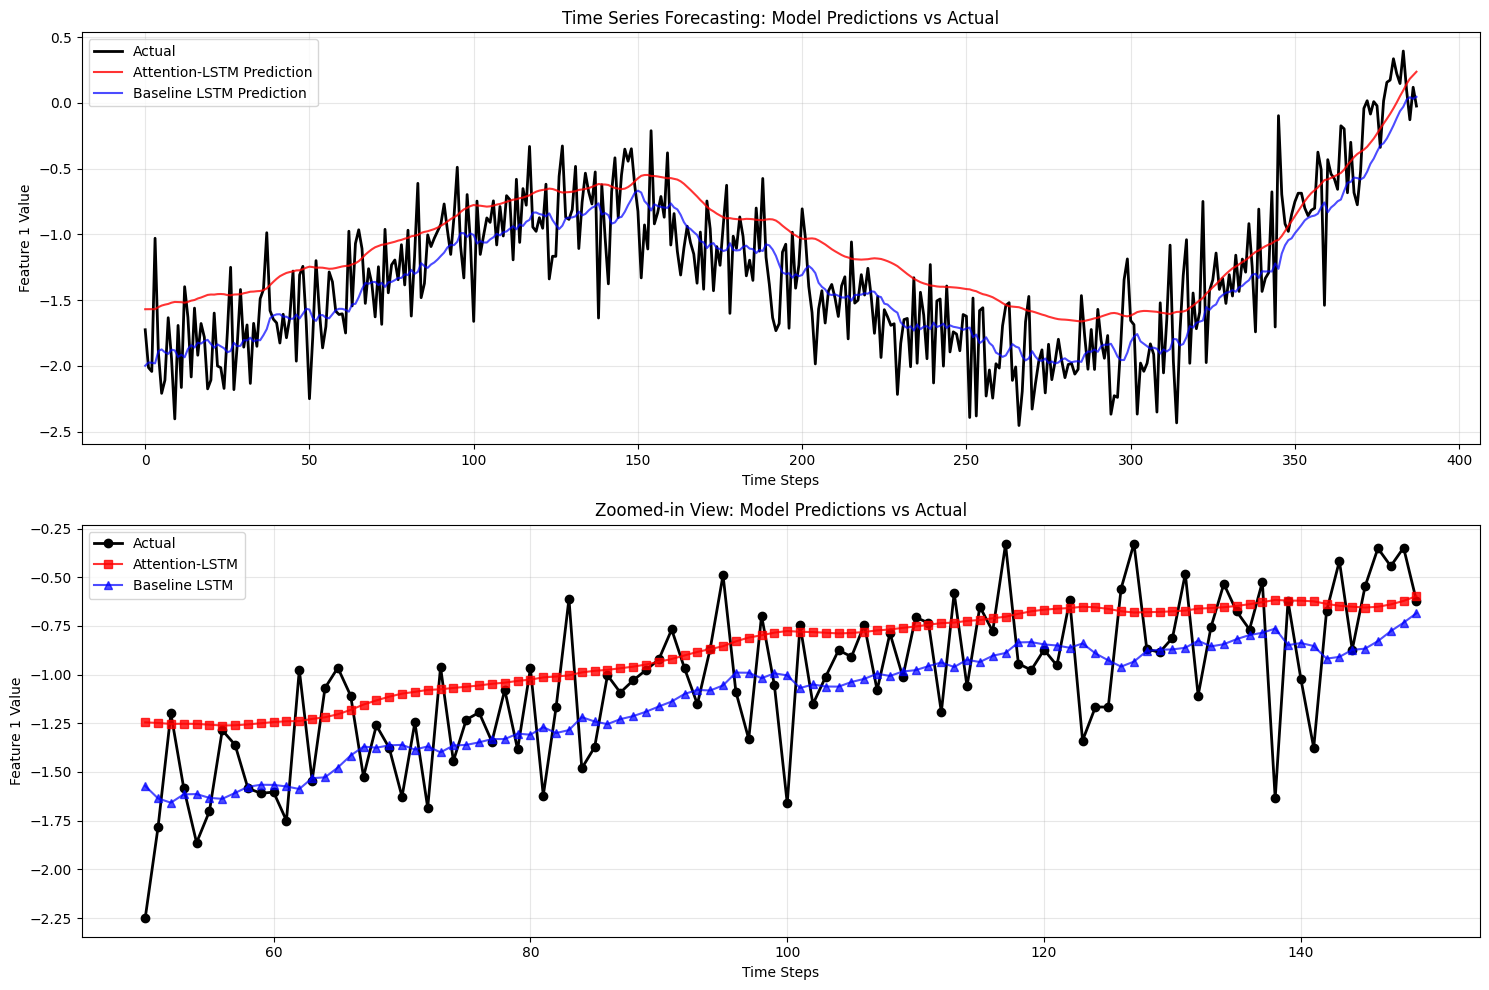

In [6]:
# Evaluate models
print("Evaluating models...")

# Attention-LSTM evaluation
attention_rmse, attention_mae, attention_pred, attention_actual = trainer.evaluate_model(
    attention_model, X_test, y_test, preprocessor, 0
)

# Baseline LSTM evaluation
baseline_rmse, baseline_mae, baseline_pred, baseline_actual = trainer.evaluate_model(
    baseline_model, X_test, y_test, preprocessor, 0
)

print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(f"{'Model':<20} {'RMSE':<10} {'MAE':<10} {'Improvement':<15}")
print("-"*50)
print(f"{'Attention-LSTM':<20} {attention_rmse:<10.4f} {attention_mae:<10.4f} {'-':<15}")
print(f"{'Baseline LSTM':<20} {baseline_rmse:<10.4f} {baseline_mae:<10.4f} {'-':<15}")
print(f"{'Improvement %':<20} {'-':<10} {'-':<10} {((baseline_rmse - attention_rmse) / baseline_rmse * 100):<15.2f}%")
print("="*50)

# Visualize predictions
test_indices = np.arange(len(attention_actual))

plt.figure(figsize=(15, 10))

# Plot full test set comparison
plt.subplot(2, 1, 1)
plt.plot(test_indices, attention_actual, label='Actual', color='black', linewidth=2)
plt.plot(test_indices, attention_pred, label='Attention-LSTM Prediction', color='red', alpha=0.8)
plt.plot(test_indices, baseline_pred, label='Baseline LSTM Prediction', color='blue', alpha=0.7)
plt.title('Time Series Forecasting: Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Feature 1 Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot a zoomed-in section
zoom_start, zoom_end = 50, 150
plt.subplot(2, 1, 2)
plt.plot(test_indices[zoom_start:zoom_end], attention_actual[zoom_start:zoom_end], 
         label='Actual', color='black', linewidth=2, marker='o')
plt.plot(test_indices[zoom_start:zoom_end], attention_pred[zoom_start:zoom_end], 
         label='Attention-LSTM', color='red', alpha=0.8, marker='s')
plt.plot(test_indices[zoom_start:zoom_end], baseline_pred[zoom_start:zoom_end], 
         label='Baseline LSTM', color='blue', alpha=0.7, marker='^')
plt.title('Zoomed-in View: Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Feature 1 Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analyzing attention weights...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
ATTENTION WEIGHTS ANALYSIS

Sample 1:
Predicted value: 0.5206
Attention weights distribution across input sequence:
Time steps (most recent to oldest):
t-59: [                                                  ] 0.0000
t-58: [                                                  ] 0.0000
t-57: [                                                  ] 0.0000
t-56: [                                                  ] 0.0000
t-55: [                                                  ] 0.0001
t-54: [                                                  ] 0.0001
t-53: [                                                  ] 0.0001
t-52: [                                                  ] 0.0001
t-51: [                                                  ] 0.0001
t-50: [                                                  ] 0.0001
t-49: [                                                  ] 0.0001
t-48: [                                             

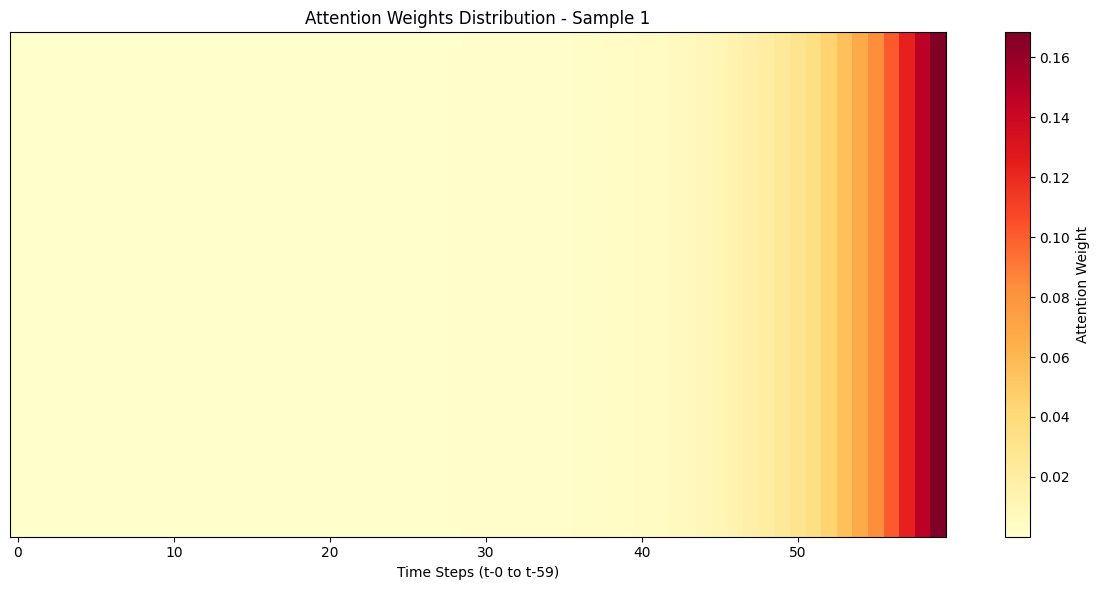


Sample 2:
Predicted value: 0.2061
Attention weights distribution across input sequence:
Time steps (most recent to oldest):
t-59: [                                                  ] 0.0007
t-58: [                                                  ] 0.0008
t-57: [                                                  ] 0.0009
t-56: [                                                  ] 0.0009
t-55: [                                                  ] 0.0010
t-54: [                                                  ] 0.0010
t-53: [                                                  ] 0.0011
t-52: [                                                  ] 0.0011
t-51: [                                                  ] 0.0013
t-50: [                                                  ] 0.0013
t-49: [                                                  ] 0.0013
t-48: [                                                  ] 0.0014
t-47: [                                                  ] 0.0014
t-46: [          

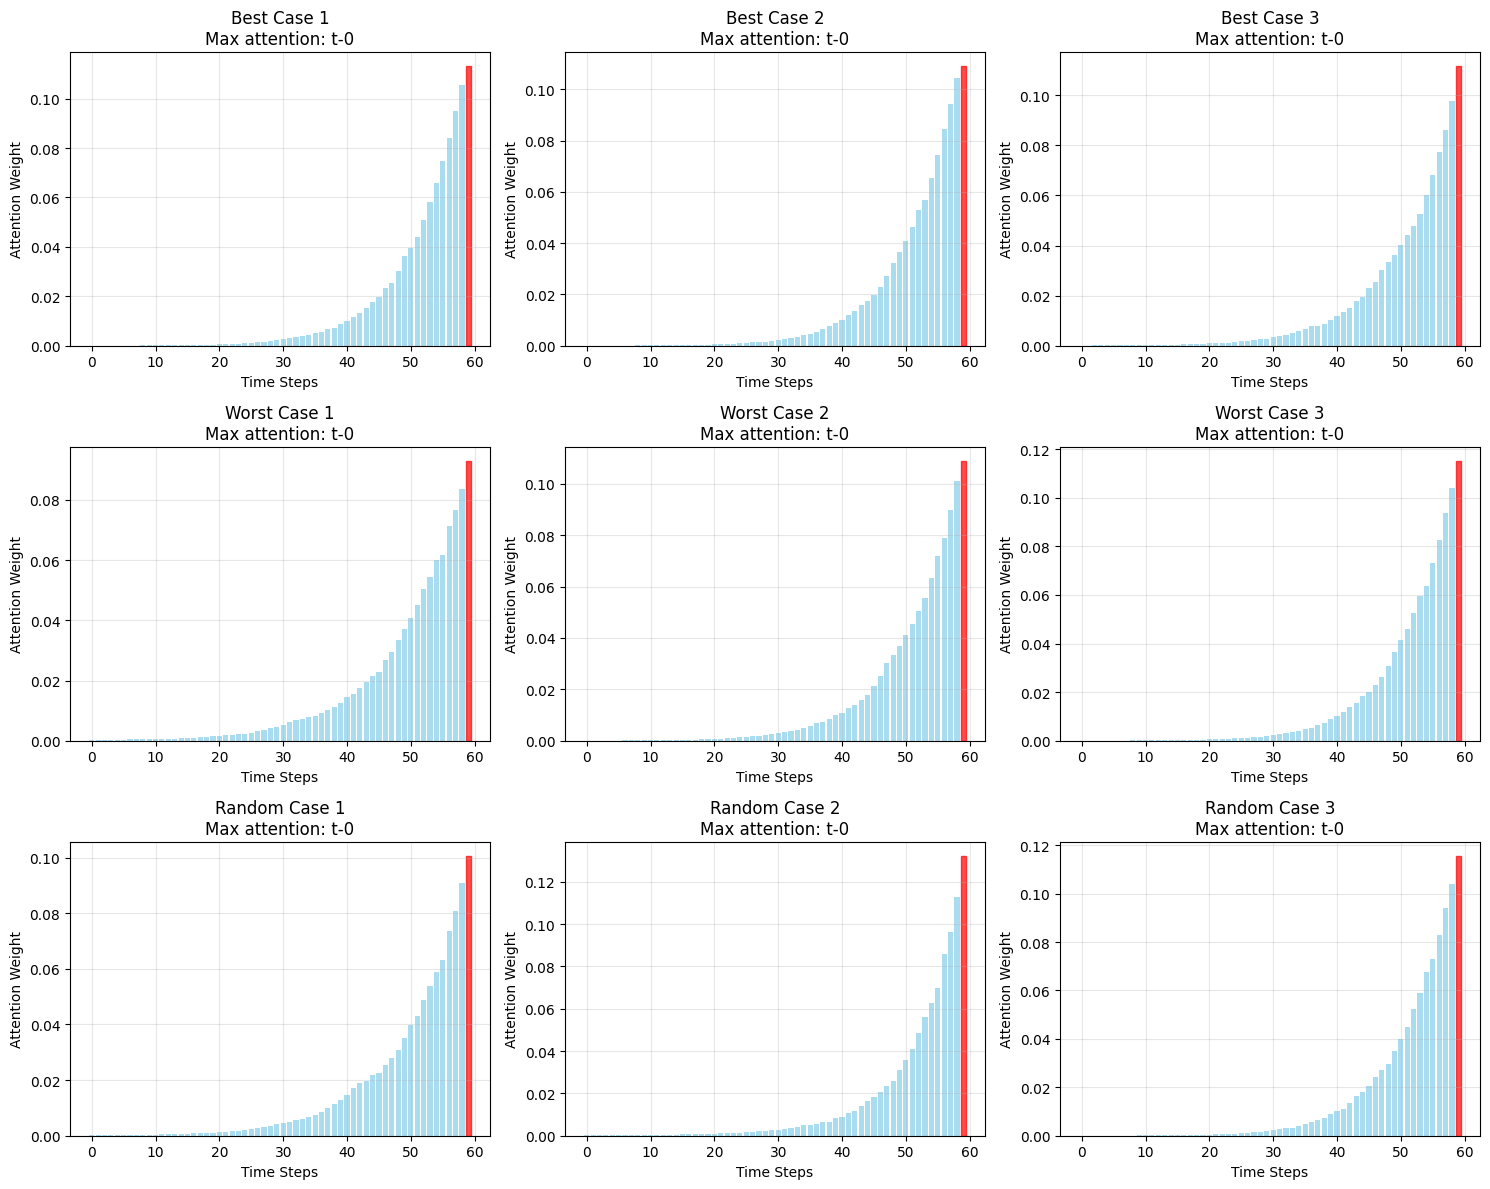


ATTENTION ANALYSIS SUMMARY
Case Type    Sample Index    Max Attention Step   Max Weight   Pred Error  
--------------------------------------------------------------------------------
Best         94              t-0                   0.1132       0.0017      
Best         139             t-0                   0.1090       0.0021      
Best         201             t-0                   0.1116       0.0023      
Worst        229             t-0                   0.0929       0.9759      
Worst        50              t-0                   0.1089       1.0047      
Worst        138             t-0                   0.1151       1.0197      
Random       219             t-0                   0.1005       0.2711      
Random       343             t-0                   0.1322       0.3920      
Random       112             t-0                   0.1155       0.4579      


In [7]:
def analyze_attention_weights(attention_model, X_samples, seq_length, n_samples=5):
    """
    Analyze and visualize attention weights for sample predictions
    """
    # Get predictions and attention weights
    predictions, attention_weights = attention_model.predict(X_samples[:n_samples])
    
    print("ATTENTION WEIGHTS ANALYSIS")
    print("="*60)
    
    for i in range(n_samples):
        print(f"\nSample {i+1}:")
        print(f"Predicted value: {predictions[i][0]:.4f}")
        print("Attention weights distribution across input sequence:")
        
        # Get attention weights for this sample
        weights = attention_weights[i].flatten()
        
        # Create ASCII visualization
        max_weight = np.max(weights)
        min_weight = np.min(weights)
        
        print("Time steps (most recent to oldest):")
        for j, weight in enumerate(weights):
            # Normalize weight for visualization
            normalized_weight = (weight - min_weight) / (max_weight - min_weight) if max_weight > min_weight else 0.5
            bar_length = int(normalized_weight * 50)
            bar = '█' * bar_length + ' ' * (50 - bar_length)
            time_step_label = f"t-{seq_length - j - 1:02d}"
            print(f"{time_step_label}: [{bar}] {weight:.4f}")
        
        # Create proper heatmap visualization for the first sample
        if i == 0:
            plt.figure(figsize=(12, 6))
            plt.imshow(weights.reshape(1, -1), cmap='YlOrRd', aspect='auto')
            plt.colorbar(label='Attention Weight')
            plt.title(f'Attention Weights Distribution - Sample {i+1}')
            plt.xlabel('Time Steps (t-0 to t-59)')
            plt.yticks([])
            plt.tight_layout()
            plt.show()

# Analyze attention weights for test samples
print("Analyzing attention weights...")
sample_indices = np.random.choice(len(X_test), size=10, replace=False)
X_samples = X_test[sample_indices]

analyze_attention_weights(attention_model_with_weights, X_samples, SEQ_LENGTH, n_samples=3)

# Additional analysis: Compare attention patterns for different scenarios
def comprehensive_attention_analysis(attention_model, X_test, y_test, preprocessor, n_cases=3):
    """
    Comprehensive analysis of attention weights for different prediction scenarios
    """
    cases = []
    
    # Find samples with different characteristics
    predictions, attention_weights = attention_model.predict(X_test)
    predictions = predictions.flatten()
    
    # Case 1: Best predictions (lowest error)
    actual_values = preprocessor.inverse_transform(y_test, 0)
    pred_values = preprocessor.inverse_transform(predictions.reshape(-1, 1), 0)
    errors = np.abs(actual_values - pred_values)
    
    best_idx = np.argsort(errors)[:n_cases]
    worst_idx = np.argsort(errors)[-n_cases:]
    random_idx = np.random.choice(len(X_test), n_cases, replace=False)
    
    all_cases = list(best_idx) + list(worst_idx) + list(random_idx)
    case_types = ['Best'] * n_cases + ['Worst'] * n_cases + ['Random'] * n_cases
    
    plt.figure(figsize=(15, 12))
    
    for i, (idx, case_type) in enumerate(zip(all_cases, case_types)):
        weights = attention_weights[idx].flatten()
        
        plt.subplot(3, 3, i + 1)
        bars = plt.bar(range(len(weights)), weights, color='skyblue', alpha=0.7)
        
        # Highlight highest weight
        max_idx = np.argmax(weights)
        bars[max_idx].set_color('red')
        
        plt.title(f'{case_type} Case {i % n_cases + 1}\nMax attention: t-{SEQ_LENGTH - max_idx - 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Attention Weight')
        plt.grid(True, alpha=0.3)
        
        # Store case information
        cases.append({
            'type': case_type,
            'index': idx,
            'max_attention_step': SEQ_LENGTH - max_idx - 1,
            'max_weight': weights[max_idx],
            'prediction_error': errors[idx]
        })
    
    plt.tight_layout()
    plt.show()
    
    return cases

print("\nComprehensive Attention Analysis...")
cases_analysis = comprehensive_attention_analysis(
    attention_model_with_weights, X_test, y_test, preprocessor, n_cases=3
)

# Print analysis summary
print("\nATTENTION ANALYSIS SUMMARY")
print("="*80)
print(f"{'Case Type':<12} {'Sample Index':<15} {'Max Attention Step':<20} {'Max Weight':<12} {'Pred Error':<12}")
print("-"*80)
for case in cases_analysis:
    print(f"{case['type']:<12} {case['index']:<15} t-{case['max_attention_step']:<19} {case['max_weight']:<12.4f} {case['prediction_error']:<12.4f}")

In [8]:
def hyperparameter_study(X_tr, y_tr, X_val, y_val, preprocessor):
    """
    Conduct a simplified hyperparameter optimization study
    """
    print("CONDUCTING HYPERPARAMETER OPTIMIZATION STUDY")
    print("="*60)
    
    # Define parameter grid
    param_grid = {
        'lstm_units': [32, 64, 128],
        'learning_rate': [0.001, 0.0005, 0.0001],
        'batch_size': [16, 32, 64]
    }
    
    best_score = float('inf')
    best_params = {}
    results = []
    
    # Simplified grid search (for demonstration)
    for lstm_units in param_grid['lstm_units']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                print(f"\nTesting: LSTM units={lstm_units}, LR={learning_rate}, Batch={batch_size}")
                
                try:
                    # Create and train model
                    model, _ = create_attention_lstm_model(
                        SEQ_LENGTH, X_tr.shape[2], 
                        lstm_units=lstm_units, 
                        learning_rate=learning_rate
                    )
                    
                    # Train with early stopping
                    early_stopping = keras.callbacks.EarlyStopping(
                        patience=10, restore_best_weights=True
                    )
                    
                    history = model.fit(
                        X_tr, y_tr,
                        batch_size=batch_size,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0
                    )
                    
                    # Evaluate
                    val_loss = min(history.history['val_loss'])
                    
                    results.append({
                        'lstm_units': lstm_units,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'val_loss': val_loss
                    })
                    
                    print(f"Validation Loss: {val_loss:.4f}")
                    
                    if val_loss < best_score:
                        best_score = val_loss
                        best_params = {
                            'lstm_units': lstm_units,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size
                        }
                        
                except Exception as e:
                    print(f"Error: {e}")
                    continue
    
    print("\n" + "="*60)
    print("HYPERPARAMETER OPTIMIZATION RESULTS")
    print("="*60)
    print(f"Best validation loss: {best_score:.4f}")
    print(f"Best parameters: {best_params}")
    
    # Display results table
    print("\nDetailed Results:")
    print(f"{'LSTM Units':<12} {'Learning Rate':<15} {'Batch Size':<12} {'Val Loss':<12}")
    print("-"*60)
    for result in sorted(results, key=lambda x: x['val_loss']):
        print(f"{result['lstm_units']:<12} {result['learning_rate']:<15} {result['batch_size']:<12} {result['val_loss']:<12.4f}")
    
    return best_params, results

# Run hyperparameter study
best_params, study_results = hyperparameter_study(X_tr, y_tr, X_val, y_val, preprocessor)

CONDUCTING HYPERPARAMETER OPTIMIZATION STUDY

Testing: LSTM units=32, LR=0.001, Batch=16
Validation Loss: 0.0037

Testing: LSTM units=32, LR=0.001, Batch=32
Validation Loss: 0.0153

Testing: LSTM units=32, LR=0.001, Batch=64
Validation Loss: 0.0190

Testing: LSTM units=32, LR=0.0005, Batch=16
Validation Loss: 0.0119

Testing: LSTM units=32, LR=0.0005, Batch=32
Validation Loss: 0.0181

Testing: LSTM units=32, LR=0.0005, Batch=64
Validation Loss: 0.0093

Testing: LSTM units=32, LR=0.0001, Batch=16
Validation Loss: 0.0124

Testing: LSTM units=32, LR=0.0001, Batch=32
Validation Loss: 0.0140

Testing: LSTM units=32, LR=0.0001, Batch=64
Validation Loss: 0.0109

Testing: LSTM units=64, LR=0.001, Batch=16
Validation Loss: 0.0047

Testing: LSTM units=64, LR=0.001, Batch=32
Validation Loss: 0.0045

Testing: LSTM units=64, LR=0.001, Batch=64
Validation Loss: 0.0117

Testing: LSTM units=64, LR=0.0005, Batch=16
Validation Loss: 0.0061

Testing: LSTM units=64, LR=0.0005, Batch=32
Validation Loss: 0.